### Pool of upwelled water and tracer for 8Tr in Astoria and Barkley bathymetries

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import matplotlib.gridspec as gspec

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [30]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*nz - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomAnom(Tr, hfac, ra, bathy,nz, sbdepth=-152.5):
    '''Tr: Tracer field-Tr field no canyon (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*nz - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                

        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,X,Y,xslice,yslice,colmap, cmin=-1, cmax=1):
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,20,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.5,0.6,0.8,1.0,1.2],colors='k')
    plt.clabel(cs)
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

def PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                xslice_pl, yslice_pl, nz,
                hFacA, rAA, DepthA, XA, YA,
                hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        
        mesh1 = PlotPool(ax1,ConcLinA/nbl.variables[key][0,30,50,50],XA, YA,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh1, ax=ax1)
    
    with Dataset(ptr_fileB, 'r') as nbl:
        ConcAreaLinB, ConcLinB, AreaTrB = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacB,rAB,DepthB, nz-1,sbdepth=sbdepthB)
        
        mesh2 = PlotPool(ax2,ConcLinB/nbl.variables[key][0,40,50,50],XB, YB,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh2, ax=ax2)
        
    for ax in [ax1,ax2]:
        ax.set_facecolor("darkgrey")
        ax.set_ylabel('Cross-shelf / km')

    ax1.set_xlabel('CS distance / km')
    ax1.set_title('Astoria')
    ax2.set_xlabel('CS distance / km')
    ax2.set_title('Barkley day %1.1f' %(tt/2))

    ax1.set_aspect(1)
    return(ax1, ax2)

In [11]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_8TR/03_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_8TR/03_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/01_Ast03/gridGlob.nc'

In [18]:
nz = 104

with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]

### 01 - Initial profiles

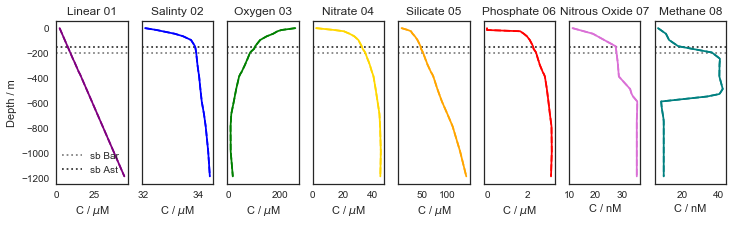

In [36]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08']
colours = ['purple','blue','green','gold','orange','red','orchid','teal']

fig,ax = plt.subplots(1,len(tracers),figsize=(12,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]

        ax[ii].plot(tr_profile, Z, color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Initial profiles. Profiles for both runs plotted to check they are actually the same.

### 02 - Shelf-bottom pool 

Linear tracer (Tr01) 

Tracer gradients below shelf-break depth are the same for both canyons. This is the "base case" pool where both canyons have the same N,f, almost same U, and same dTr/dz at shelf-break depth.

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


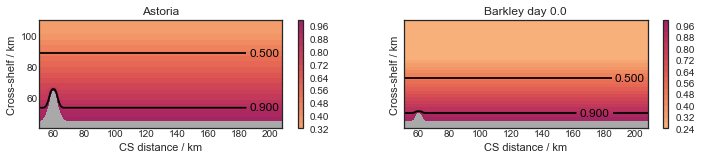

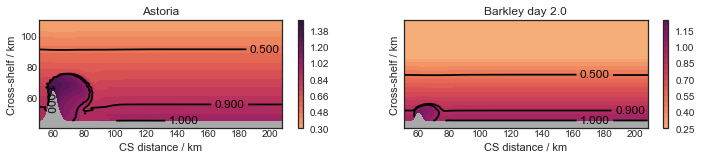

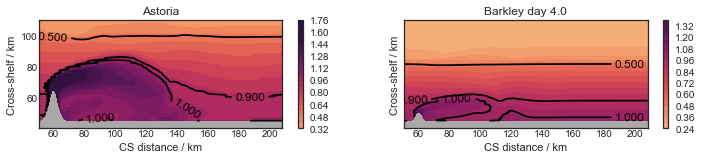

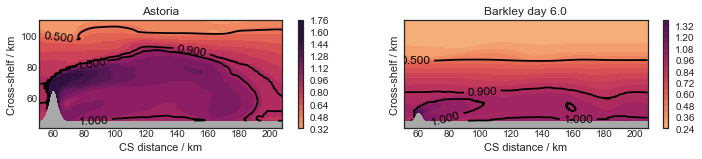

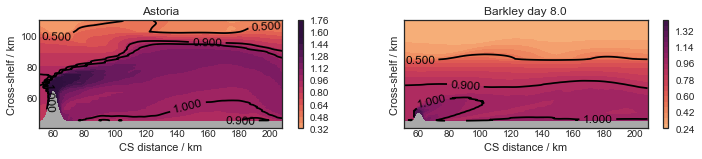

In [21]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr01'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
    

Salinity (Tr02)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


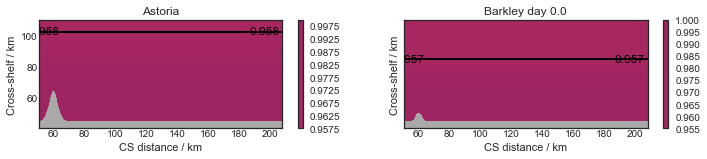

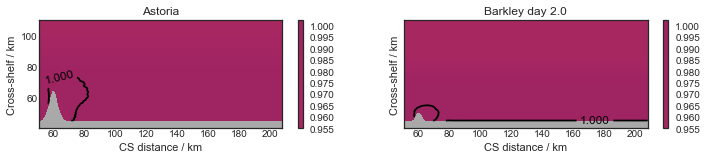

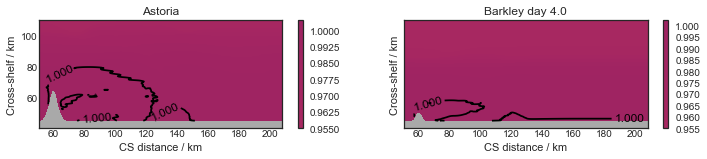

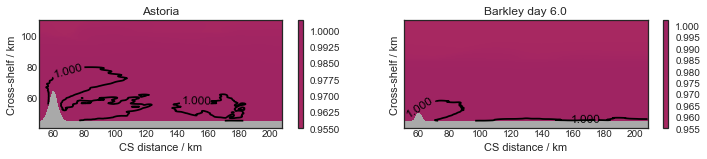

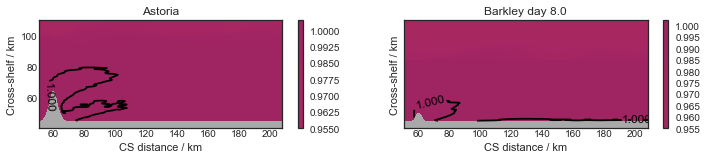

In [22]:
key = 'Tr02'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
  

Oxygen (Tr03)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


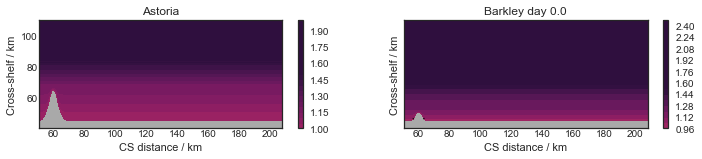

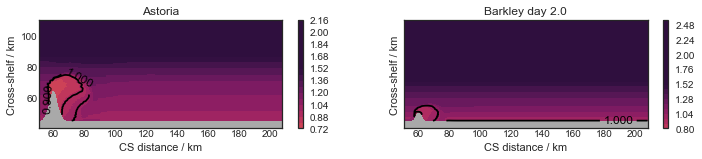

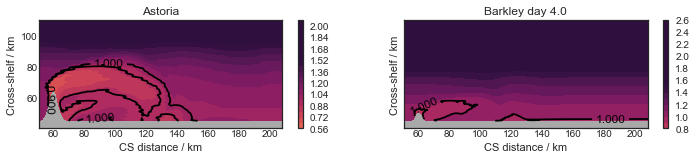

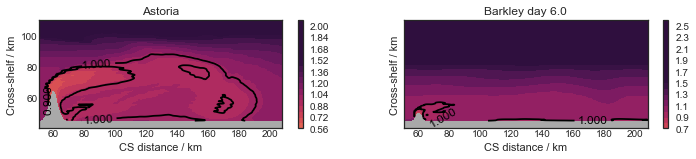

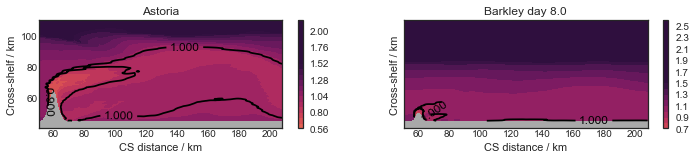

In [23]:
key = 'Tr03'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)


Nitrate (Tr04)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


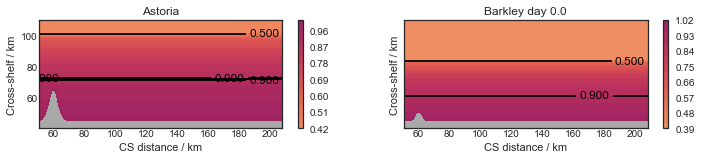

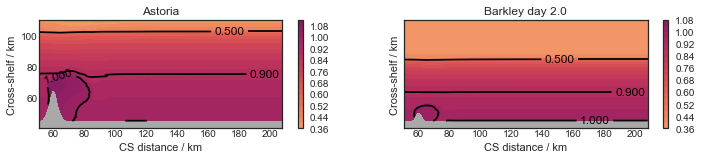

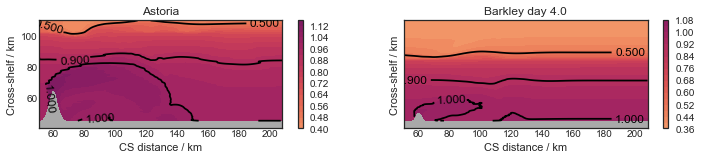

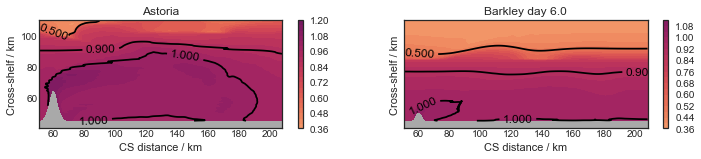

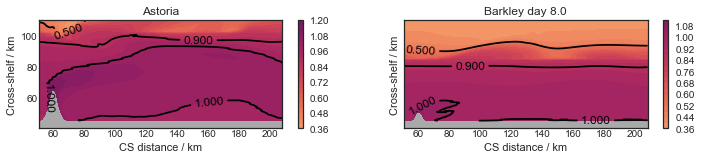

In [24]:
key = 'Tr04'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)


Silicate (Tr05)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


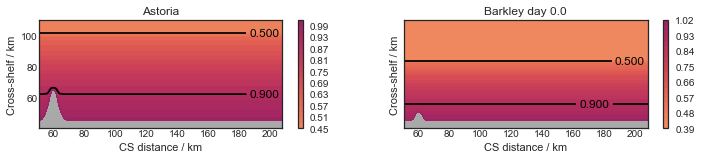

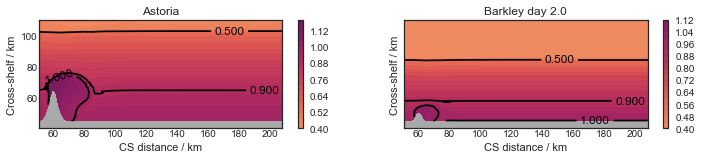

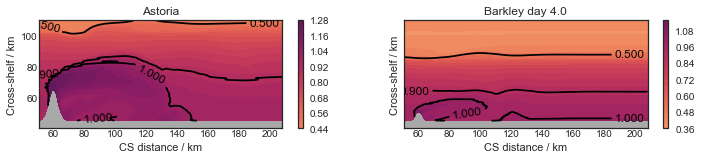

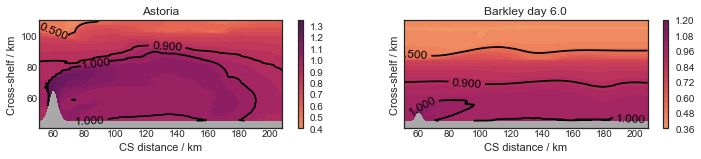

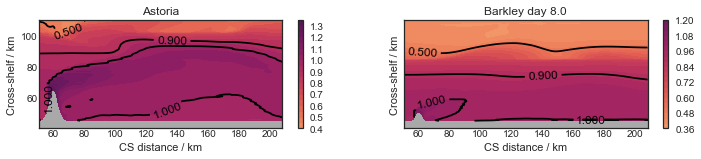

In [26]:
key = 'Tr05'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)


Phosphate (Tr06)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


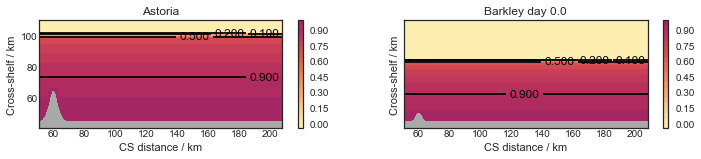

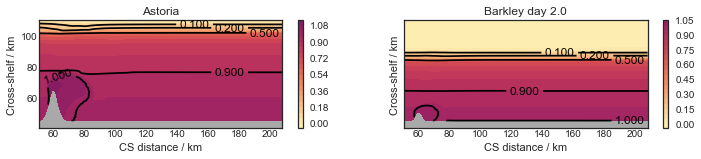

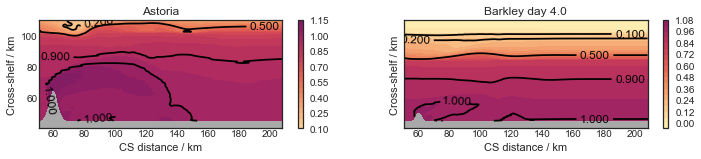

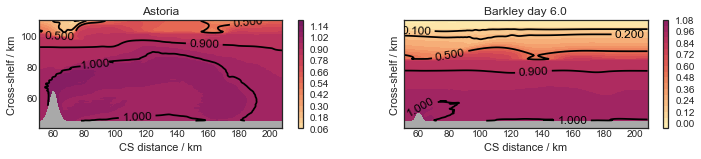

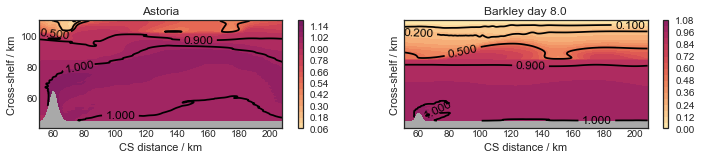

In [27]:
key = 'Tr06'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)


Nitrous Oxide (Tr07)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


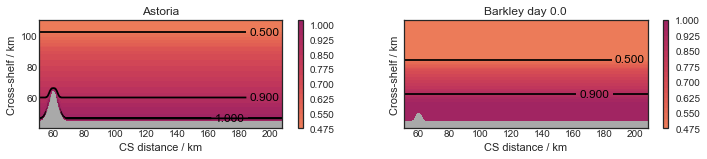

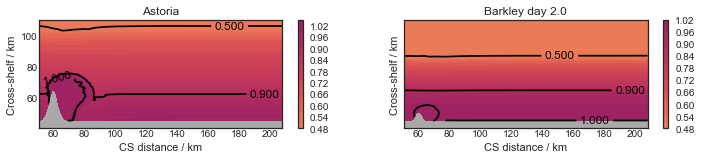

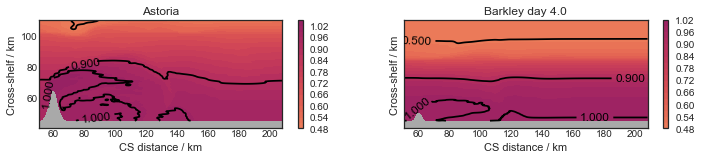

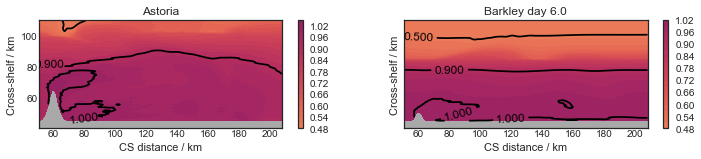

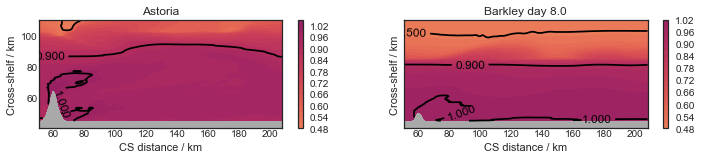

In [28]:
key = 'Tr07'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)


Methane (Tr08)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


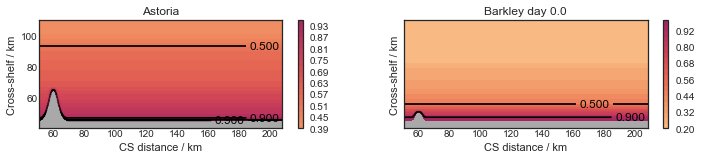

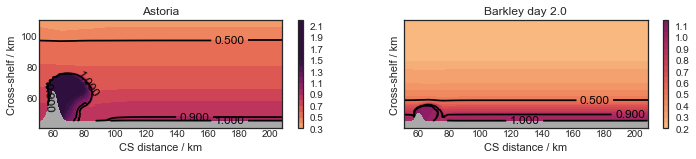

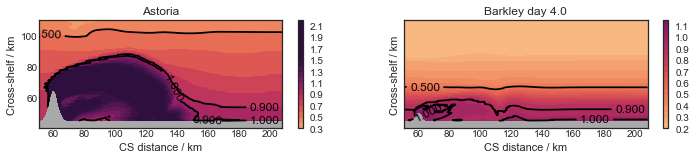

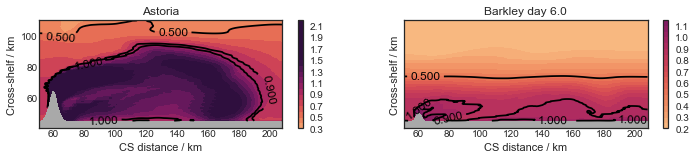

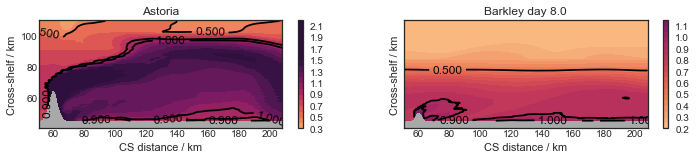

In [29]:
key = 'Tr08'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)


Which one is larger?

Which one has higher concentration on average?

Depth of largest gradients vs shelf?

What matters is the tracer gradient below shelf break depth, but how deep is "below"? at shelf-break depth, Z (depth of upwelling), other scale?

Does gradient above matter?

Maybe I should also run a Barkley with same sb depth as Astoria or the opposite...